# Emulate the RFMIP forcing from other SSPs

Forcing from SSPs is provided from a combination of

- greenhouse gases
- aerosols
- solar & volcanic (combined "natural")
- other anthropogenic
  - land use change
  - ozone
  
We wish to use the SSP2-4.5 model-specific ERFs from RFMIP and apply them to other scenarios. Do as follows:
- Greenhouse gases: isolate CO2 from other GHGs based on 4xCO2 and 2014 GHG ERFs. For other GHGs, scale the contribution of each according to Etminan/Meinshauen formulas.
- Aerosols: use emissions-based emulator developed in Smith et al. (2021)
- Solar and volcanic: can use RFMIP transient scenarios without modification
- Other anthropogenic:
  - land use change: use 2014 Tier 1 values, scale the time series to cumulative CO2 emissions 
  - ozone: residual of total - natural - aerosol - ghg - landuse

In [1]:
import errno
import json
import os
import urllib

from fair.forcing.ghg import meinshausen
import matplotlib.pyplot as pl
from netCDF4 import Dataset
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

In [2]:
scenarios = ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp434', 'ssp460', 'ssp534-over', 'ssp585']
emitted_species = ['BC', 'OC', 'Sulfur']
emissions = {}

In [3]:
def mkdir_p(path):
    """Check to see if directory exists, and if not, create it.
    Parameters
    ----------
        path : str
            directory to create
    Raises
    ------
        OSError:
            if directory cannot be created
    """
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

In [4]:
def check_and_download(filepath, url):
    """Checks prescence of a file and downloads if not present.

    Inputs
    ------
        filepath : str
            filename to download to
        url :
            url to download from
    """
    if not os.path.isfile(filepath):
        urllib.request.urlretrieve(url, filepath)
    return

In [5]:
check_and_download('../data_input/rcmip/rcmip-emissions-annual-means-v5-1-0.csv', 'https://rcmip-protocols-au.s3-ap-southeast-2.amazonaws.com/v5.1.0/rcmip-emissions-annual-means-v5-1-0.csv')

In [6]:
rfmip_tier2 = pd.read_csv('../data_input/RFMIP-ERF-tier2.csv', index_col=0)

## Aerosols will be easiest

In [7]:
emissions_df = pd.read_csv('../data_input/rcmip/rcmip-emissions-annual-means-v5-1-0.csv')

In [8]:
for scenario in scenarios:
    emissions[scenario] = {}
    for specie in emitted_species:
        emissions[scenario][specie] = emissions_df.loc[
            (emissions_df['Scenario']==scenario) & 
            (emissions_df['Variable']=='Emissions|{}'.format(specie)) &
            (emissions_df['Region']=='World'), 
            '1850':'2100'
        ].interpolate(axis=1).values.squeeze()

In [9]:
with open('../data_output/cmip6_aerosol_coefficients.json') as f:
    aerosol_tunings = json.load(f)

In [10]:
models = [
    'CanESM5',
    'CNRM-CM6-1',
    'GFDL-CM4',
    'GISS-E2-1-G',
    'HadGEM3-GC31-LL',
    'IPSL-CM6A-LR',
    'MIROC6',
    'NorESM2-LM',
]

In [11]:
models

['CanESM5',
 'CNRM-CM6-1',
 'GFDL-CM4',
 'GISS-E2-1-G',
 'HadGEM3-GC31-LL',
 'IPSL-CM6A-LR',
 'MIROC6',
 'NorESM2-LM']

In [12]:
aerosol_tunings[models[0]]['ERFari']['BC']

0.03259343948789619

In [13]:
erf = {}
for model in models:
    erf[model] = {}
    for scenario in scenarios:
        erf[model][scenario] = {}

In [14]:
def aerocom(x, bc, oc, so2):
    return bc*x[0] + oc*x[1] + so2*x[2]

def ghan(x, beta, n0, n1):
    return -beta*np.log(1 + x[0]/n0 + x[1]/n1)

In [15]:
for model in models:
    for scenario in scenarios:
        x_ari = np.array([emissions[scenario]['BC'], emissions[scenario]['OC'], emissions[scenario]['Sulfur']])
        x_aci = np.array([emissions[scenario]['Sulfur'], emissions[scenario]['BC']+emissions[scenario]['OC']])
        erf[model][scenario]['aerosol'] = (
            aerocom(
                x_ari,
                aerosol_tunings[model]['ERFari']['BC'],
                aerosol_tunings[model]['ERFari']['OC'],
                aerosol_tunings[model]['ERFari']['SO2'],
            ) - aerocom(
                x_ari[:, 0],
                aerosol_tunings[model]['ERFari']['BC'],
                aerosol_tunings[model]['ERFari']['OC'],
                aerosol_tunings[model]['ERFari']['SO2'],
            )
        ) + (
            ghan(
                x_aci,
                aerosol_tunings[model]['ERFaci']['beta'],
                aerosol_tunings[model]['ERFaci']['n0'],
                aerosol_tunings[model]['ERFaci']['n1'],
            ) - ghan(
                x_aci[:, 0],
                aerosol_tunings[model]['ERFaci']['beta'],
                aerosol_tunings[model]['ERFaci']['n0'],
                aerosol_tunings[model]['ERFaci']['n1'],
            )
        )

In [16]:
# replace historcial with model results
for model in models:
    for scenario in scenarios:
        erf[model][scenario]['aerosol'][:165] = rfmip_tier2.loc[:2014, '%s AER' % model]
        
#     if model not in ['NorESM2-LM', 'CNRM-CM6-1', 'HadGEM3-GC31-LL']:
#         erf[model]['ssp245']['aerosol'][165:] = rfmip_tier2.loc[2015:, '%s AER' % model]
    
#     if model=='HadGEM3-GC31-LL':
#         erf[model]['ssp245']['aerosol'][165:250] = rfmip_tier2.loc[2015:2099, '%s AER' % model]

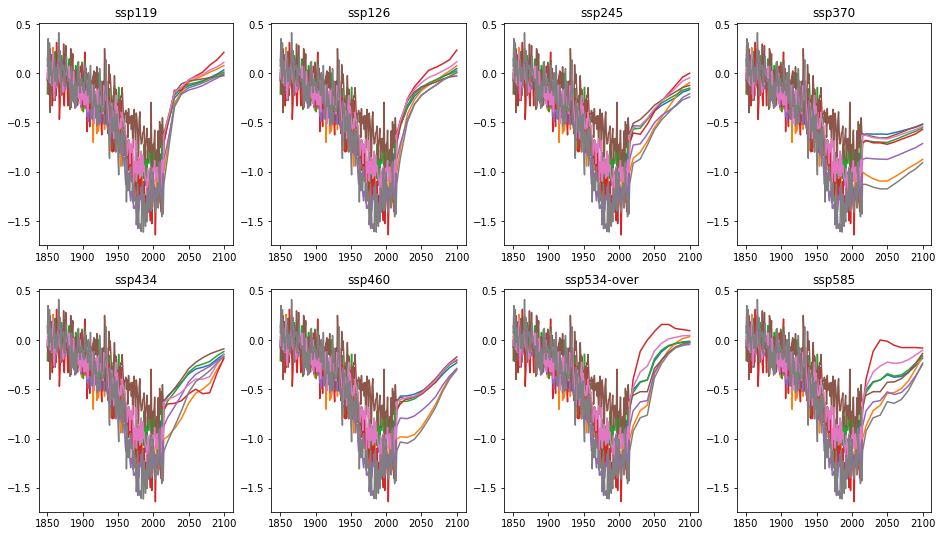

In [17]:
fig, ax = pl.subplots(2, 4, figsize=(16,9))

for iscen, scenario in enumerate(scenarios):
    for model in models:
        ax[iscen//4, iscen%4].plot(np.arange(1850, 2101), erf[model][scenario]['aerosol'])
        ax[iscen//4, iscen%4].set_title(scenario)

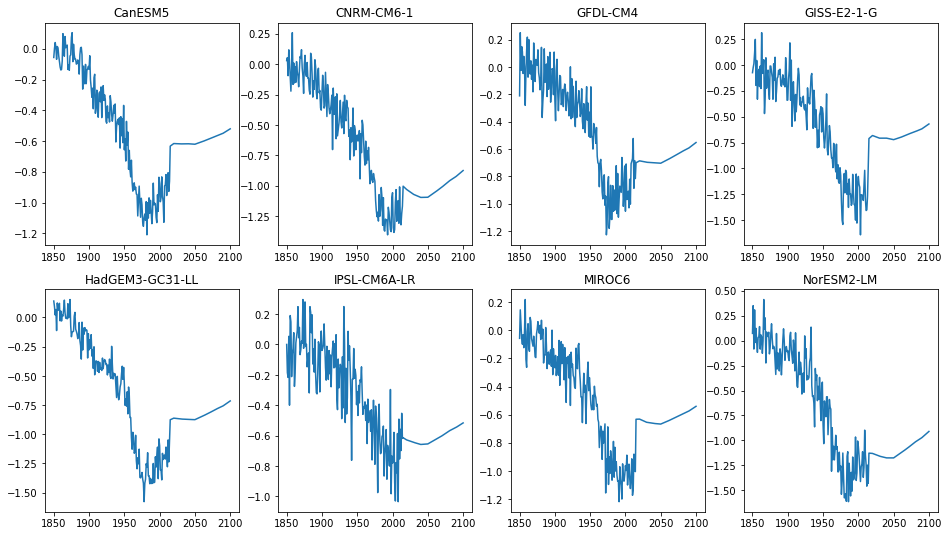

In [18]:
fig, ax = pl.subplots(2, 4, figsize=(16,9))

for imod, model in enumerate(models):
    ax[imod//4, imod%4].plot(np.arange(1850, 2101), erf[model]['ssp370']['aerosol'])
    ax[imod//4, imod%4].set_title(model)

## Natural will be second easiest

- Isolate volcanic and solar in the 8 models
- We know that volcanic ramps to zero 2015-2024, so any residual natural forcing is solar in any model that didn't run the natural experiment beyond 2014

In [19]:
# only need to fill in HadGEM3 for 2100, CNRM and NorESM2
natural = rfmip_tier2[['CanESM5 NAT', 'CNRM-CM6-1 NAT', 'GFDL-CM4 NAT', 'GISS-E2-1-G NAT', 'HadGEM3-GC31-LL NAT', 'IPSL-CM6A-LR NAT', 'MIROC6 NAT', 'NorESM2-LM NAT']]
natural

,CanESM5 NAT,CNRM-CM6-1 NAT,GFDL-CM4 NAT,GISS-E2-1-G NAT,HadGEM3-GC31-LL NAT,IPSL-CM6A-LR NAT,MIROC6 NAT,NorESM2-LM NAT
year,,,,,,,,
1850,0.437284,-0.293584,0.127826,0.109629,0.217894,0.193991,-0.037077,0.351767
1851,0.003158,-0.229548,0.223375,-0.329789,0.280323,0.193944,0.231050,0.195244
1852,-0.202280,-0.012110,0.199512,0.149565,0.137737,-0.098239,0.075457,-0.077189
1853,-0.161843,-0.170152,0.166399,-0.105968,0.189263,0.219294,-0.145791,0.339919
1854,0.061468,-0.003006,0.364801,0.011749,0.158687,0.168342,0.149833,-0.216705
...,...,...,...,...,...,...,...,...
2096,0.154930,NaN,-0.133315,0.181825,0.103691,0.169500,0.163041,NaN
2097,0.008238,NaN,-0.067166,-0.009377,0.154095,0.008598,0.014279,NaN
2098,-0.016735,NaN,-0.162721,0.127037,0.031064,0.134732,-0.153561,NaN


In [20]:
# Reproduce the solar forcing calculation

nc_future = Dataset('../data_input/input4mips/solarforcing-ref-mon_input4MIPs_solar_CMIP_SOLARIS-HEPPA-3-2_gn_185001-229912.nc')
tsi_future = nc_future.variables['tsi'][:(251*12)]
nc_future.close()

years = np.arange(1850, 2101, dtype=int)
isleap = np.zeros(251)
isleap[np.logical_and(years%4==0, np.logical_or(years%100!=0, years%400==0))] = 1

tsi = np.zeros(251)
for i, year in enumerate(years):
    weights = [31,28+isleap[i],31,30,31,30,31,31,30,31,30,31]
    tsi[i] = np.average(tsi_future[(i)*12:(1+i)*12], weights=weights)

tsi_baseline = np.mean(tsi[:24])
tsi_baseline
solar_erf = 0.25 * (tsi-tsi_baseline) * 0.71 * 0.72  # include RA

In [21]:
for model in models:
    for scenario in scenarios:
        erf[model][scenario]['natural'] = natural.loc[:, '%s NAT' % model].values

In [22]:
for scenario in scenarios:
    erf['HadGEM3-GC31-LL'][scenario]['natural'][250] = solar_erf[250]

In [23]:
for model in ['CNRM-CM6-1', 'NorESM2-LM']:
    for scenario in scenarios:
        erf[model][scenario]['natural'][174:] = solar_erf[174:]
        erf[model][scenario]['natural'][165:174] = (natural.loc[2014, '%s NAT' % model] - solar_erf[164]) * np.linspace(0.9,0.1,9) + solar_erf[165:174]

In [24]:
(natural.loc[2014, '%s NAT' % model] - solar_erf[164]) * np.linspace(0.9,0.1,9) + solar_erf[165:174]

array([-0.00727194, -0.03914519, -0.04409948, -0.04317538, -0.03895563,
       -0.02882632,  0.01262463,  0.05738552,  0.08489913])

In [25]:
erf[model][scenario]['natural']

array([ 3.51766762e-01,  1.95244099e-01, -7.71886611e-02,  3.39918933e-01,
       -2.16705422e-01,  2.48576523e-01,  1.91765264e-01,  3.33144697e-01,
        4.81657592e-01,  3.23124181e-01,  2.40259084e-01, -4.38974316e-01,
       -3.71809506e-01, -1.68228121e-01, -2.02487143e-01,  2.04098112e-01,
       -2.17552228e-01,  2.97724106e-02,  1.11455344e-01, -5.46826260e-02,
       -1.81695857e-02, -5.92861785e-02,  3.36247813e-01, -3.81966512e-02,
       -2.96038655e-02,  2.77229272e-01,  1.86463624e-01,  3.93925026e-01,
        3.57092328e-01,  3.40449826e-01, -2.27644899e-01,  1.87330337e-01,
        1.46098829e-01, -8.25158562e-01, -2.52381245e+00, -7.96936186e-01,
        3.74143624e-01,  6.87624202e-02,  1.03881195e-01,  2.46133096e-01,
        1.13119385e-01, -5.79577240e-01,  1.29466052e-01,  2.33712707e-01,
        5.35870291e-01, -1.36592232e-01, -1.44612995e-01,  2.39858455e-01,
       -1.54811479e-01, -2.30651445e-01,  7.63780331e-03, -5.12486321e-02,
       -4.20675643e-01, -

CanESM5
CNRM-CM6-1
GFDL-CM4
GISS-E2-1-G
HadGEM3-GC31-LL
IPSL-CM6A-LR
MIROC6
NorESM2-LM


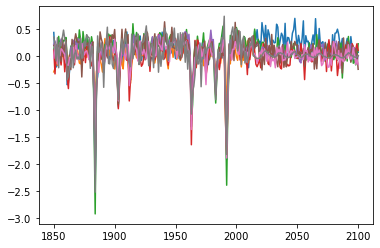

In [26]:
for model in models:
    print(model)
    pl.plot(np.arange(1850, 2101), erf[model]['ssp245']['natural'])

## Greenhouse gases

- We have SSP2-4.5, or at least historical
- estimate contributions from CO2, CH4, N2O, HFC134a-eq, CFC11-eq

In [27]:
ghg = rfmip_tier2[['CanESM5 GHG', 'CNRM-CM6-1 GHG', 'GFDL-CM4 GHG', 'GISS-E2-1-G GHG', 'HadGEM3-GC31-LL GHG', 'IPSL-CM6A-LR GHG', 'MIROC6 GHG', 'NorESM2-LM GHG']]
ghg

,CanESM5 GHG,CNRM-CM6-1 GHG,GFDL-CM4 GHG,GISS-E2-1-G GHG,HadGEM3-GC31-LL GHG,IPSL-CM6A-LR GHG,MIROC6 GHG,NorESM2-LM GHG
year,,,,,,,,
1850,-0.070117,0.030065,-0.033743,-0.071492,0.211614,0.000196,-0.190087,0.013559
1851,0.049519,-0.296073,0.033094,-0.222006,0.080624,0.123353,-0.021020,-0.174621
1852,-0.058389,-0.012057,0.055244,-0.142218,-0.125380,0.214244,0.114233,-0.026271
1853,0.058551,0.000254,0.118728,-0.071632,0.069717,-0.077474,0.108609,0.037472
1854,-0.196640,-0.007993,0.098336,-0.076394,0.330893,0.088221,0.061878,0.207066
...,...,...,...,...,...,...,...,...
2096,4.902642,NaN,5.453197,5.135131,5.546199,5.274178,4.757899,NaN
2097,5.016687,NaN,5.480755,5.151356,5.451873,5.267454,4.674509,NaN
2098,5.103812,NaN,5.675963,5.135182,5.514550,5.251549,4.684571,NaN


In [28]:
check_and_download('../data_input/rcmip/rcmip-concentrations-annual-means-v5-1-0.csv', 'https://rcmip-protocols-au.s3-ap-southeast-2.amazonaws.com/v5.1.0/rcmip-concentrations-annual-means-v5-1-0.csv')

In [29]:
radeff = {
    'HFC125':     0.23,
    'HFC134a':    0.16,
    'HFC143a':    0.16,
    'HFC152a':    0.10,
    'HFC227ea':   0.26,
    'HFC23':      0.18,
    'HFC236fa':   0.24309707,
    'HFC245fa':   0.24,
    'HFC32':      0.11,
    'HFC365mfc':  0.22261699,
    'HFC4310mee': 0.42,
    'NF3':        0.20467908,
    'C2F6':       0.25,
    'C3F8':       0.27730479,
    'C4F10':      0.36298028,
    'C5F12':      0.40512062,
    'C6F14':      0.44,
    'C7F16':      0.50171525,
    'C8F18':      0.55174034,
    'CF4':        0.09,
    'cC4F8':      0.31526465,
    'SF6':        0.57,
    'SO2F2':      0.20119879,
    'CCl4':       0.17,
    'CFC11':      0.26,
    'CFC113':     0.30,
    'CFC114':     0.31,
    'CFC115':     0.20,
    'CFC12':      0.32,
    'CH2Cl2':     0.0312,
    'CH3Br':      0.004,
    'CH3CCl3':    0.07,
    'CH3Cl':      0.01,
    'CHCl3':      0.07796969,
    'HCFC141b':   0.16,
    'HCFC142b':   0.19,
    'HCFC22':     0.21,
    'Halon1211':  0.29,
    'Halon1301':  0.30,
    'Halon2402':  0.31
}

gases=['HFC125','HFC134a','HFC143a','HFC152a','HFC227ea','HFC23','HFC236fa','HFC245fa','HFC32','HFC365mfc','HFC4310mee',
      'NF3','C2F6','C3F8','CF4','cC4F8','SF6','SO2F2','CCl4','CFC11','CFC113',
      'CFC114','CFC115','CFC12','CH2Cl2','CH3Br','CH3CCl3','CH3Cl','CHCl3','HCFC141b','HCFC142b','HCFC22','Halon1211',
      'Halon1301','Halon2402']

In [30]:
df_rcmip = pd.read_csv('../data_input/rcmip/rcmip-concentrations-annual-means-v5-1-0.csv')
conc = {}
ghg_forcing_ratio = {}
forcing = {}
for scenario in scenarios:
    conc = {}
    ghg_forcing_ratio[scenario] = {}
    conc['CO2'] = np.squeeze(df_rcmip[(df_rcmip.Scenario==scenario)&(df_rcmip.Variable=='Atmospheric Concentrations|CO2')&(df_rcmip.Region=='World')].loc[:,'1850':'2100'].values)
    conc['CH4'] = np.squeeze(df_rcmip[(df_rcmip.Scenario==scenario)&(df_rcmip.Variable=='Atmospheric Concentrations|CH4')&(df_rcmip.Region=='World')].loc[:,'1850':'2100'].values)
    conc['N2O'] = np.squeeze(df_rcmip[(df_rcmip.Scenario==scenario)&(df_rcmip.Variable=='Atmospheric Concentrations|N2O')&(df_rcmip.Region=='World')].loc[:,'1850':'2100'].values)

    for gas in gases:
        conc[gas] = np.squeeze(df_rcmip[(df_rcmip.Scenario==scenario)&(df_rcmip.Variable.str.endswith(gas))&(df_rcmip.Region=='World')].loc[:,'1850':'2100'].values)

    forcing[scenario] = {}
    forcing[scenario]["CO2"] = np.zeros(251)
    forcing[scenario]["CH4"] = np.zeros(251)
    forcing[scenario]["N2O"] = np.zeros(251)
    forcing[scenario]["Other"] = np.zeros(251)
    for gas in gases:
        for i,year in enumerate(range(1850,2101)):
            forcing[scenario]["CO2"][i], forcing[scenario]["CH4"][i], forcing[scenario]["N2O"][i] = meinshausen([conc['CO2'][i],conc['CH4'][i],conc['N2O'][i]], [conc['CO2'][0],conc['CH4'][0],conc['N2O'][0]], scale_F2x=False)
            forcing[scenario]["Other"][i] = forcing[scenario]["Other"][i] + ((conc[gas][i] - conc[gas][0]) * radeff[gas] * 0.001)
    forcing[scenario]['Total'] = forcing[scenario]["CO2"] + forcing[scenario]["CH4"] + forcing[scenario]["N2O"] + forcing[scenario]["Other"]
    ghg_forcing_ratio[scenario]['CO2'] = forcing[scenario]["CO2"]/forcing[scenario]['Total']
    ghg_forcing_ratio[scenario]['CH4'] = forcing[scenario]["CH4"]/forcing[scenario]['Total']
    ghg_forcing_ratio[scenario]['N2O'] = forcing[scenario]["N2O"]/forcing[scenario]['Total']
    ghg_forcing_ratio[scenario]['Other'] = forcing[scenario]["Other"]/forcing[scenario]['Total']

/var/folders/6q/3d6ldw_97jq9lq39ckxj292c0000gn/T/ipykernel_20214/1417851663.py:25: RuntimeWarning: invalid value encountered in true_divide
  ghg_forcing_ratio[scenario]['CO2'] = forcing[scenario]["CO2"]/forcing[scenario]['Total']
/var/folders/6q/3d6ldw_97jq9lq39ckxj292c0000gn/T/ipykernel_20214/1417851663.py:26: RuntimeWarning: invalid value encountered in true_divide
  ghg_forcing_ratio[scenario]['CH4'] = forcing[scenario]["CH4"]/forcing[scenario]['Total']
/var/folders/6q/3d6ldw_97jq9lq39ckxj292c0000gn/T/ipykernel_20214/1417851663.py:27: RuntimeWarning: invalid value encountered in true_divide
  ghg_forcing_ratio[scenario]['N2O'] = forcing[scenario]["N2O"]/forcing[scenario]['Total']
/var/folders/6q/3d6ldw_97jq9lq39ckxj292c0000gn/T/ipykernel_20214/1417851663.py:28: RuntimeWarning: invalid value encountered in true_divide
  ghg_forcing_ratio[scenario]['Other'] = forcing[scenario]["Other"]/forcing[scenario]['Total']


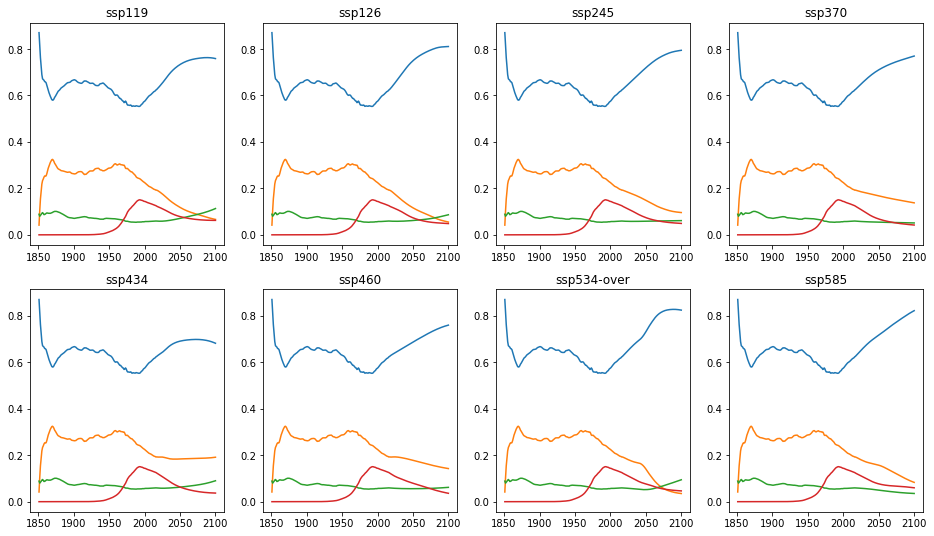

In [31]:
fig, ax = pl.subplots(2, 4, figsize=(16,9))

for iscen, scenario in enumerate(scenarios):
    for gas in ["CO2", "CH4", "N2O", "Other"]:
        ax[iscen//4, iscen%4].plot(np.arange(1850, 2101), ghg_forcing_ratio[scenario][gas])
    ax[iscen//4, iscen%4].set_title(scenario)

In [32]:
def forcing_fit(x, co2, ch4, n2o, minor):
    return co2*x[0] + ch4*x[1] + n2o*x[2] + minor*x[3]

In [33]:
ghg['CanESM5 GHG'].values

array([-7.01170344e-02,  4.95185807e-02, -5.83891046e-02,  5.85506831e-02,
       -1.96640461e-01, -7.37823377e-02,  9.58595943e-02,  9.46190286e-02,
        6.79861833e-03,  1.47775427e-01, -3.07644541e-03,  7.62569135e-02,
        8.58439433e-02,  9.46611447e-02,  5.09519254e-02,  1.04321229e-01,
        5.92866358e-02,  1.20305904e-01,  1.61790698e-01,  1.79316001e-01,
        1.50330626e-01,  1.57529352e-01,  2.08721480e-01,  1.64653925e-01,
        6.35113675e-02,  1.70877008e-01,  2.52592074e-02,  1.01330130e-01,
       -7.06359833e-02,  7.35457345e-02,  1.16823418e-01,  1.63269337e-01,
        1.24193288e-01,  2.11470638e-01,  2.22983973e-01,  2.51012350e-01,
        1.42005852e-01,  2.10831876e-01,  1.74439487e-01,  1.75285476e-01,
        9.54644717e-02,  1.62196082e-01,  3.60152724e-01,  2.18958531e-01,
        1.93640068e-01,  4.19089320e-01,  3.54994149e-01,  2.35064601e-01,
        2.35746017e-01,  1.65806813e-01,  2.37538105e-01,  4.10504003e-01,
        2.31319744e-01,  

In [34]:
ghg_scaling_factors = {}

end = {model: 251 for model in models}
end['HadGEM3-GC31-LL'] = 250
end['NorESM2-LM'] = 165
end['CNRM-CM6-1'] = 165

for model in models:
    p, cov = curve_fit(
        forcing_fit, 
        [
            forcing['ssp245']['CO2'][:end[model]],
            forcing['ssp245']['CH4'][:end[model]],
            forcing['ssp245']['N2O'][:end[model]],
            forcing['ssp245']['Other'][:end[model]]
        ],
        ghg['%s GHG' % model].values[:end[model]],
        bounds = ((0.8, 0.7, 0.7, 0.5), (1.2, 1.3, 1.3, 1.5))
    )
    ghg_scaling_factors[model] = {}
    for i, gas in enumerate(['CO2', 'CH4', 'N2O', 'Other']):
        ghg_scaling_factors[model][gas] = p[i]

In [35]:
ghg_scaling_factors

{'CanESM5': {'CO2': 0.9618685112493808,
  'CH4': 0.8596204113670127,
  'N2O': 1.0715340824934219,
  'Other': 1.3742967725858926},
 'CNRM-CM6-1': {'CO2': 0.9557496963910708,
  'CH4': 0.9544222770368753,
  'N2O': 1.2999999999238865,
  'Other': 0.5000000009741543},
 'GFDL-CM4': {'CO2': 1.0633754304447376,
  'CH4': 1.2809725204817815,
  'N2O': 1.2999999999849268,
  'Other': 0.8034937386924752},
 'GISS-E2-1-G': {'CO2': 0.9869965888001788,
  'CH4': 0.9177772846423566,
  'N2O': 0.7000000000000107,
  'Other': 1.4031485138044186},
 'HadGEM3-GC31-LL': {'CO2': 1.02085926513422,
  'CH4': 1.2409301736808989,
  'N2O': 1.2999999951206638,
  'Other': 1.020993929610269},
 'IPSL-CM6A-LR': {'CO2': 1.047300620705093,
  'CH4': 0.7000000000006775,
  'N2O': 1.2999999999999998,
  'Other': 1.0145240810178238},
 'MIROC6': {'CO2': 0.9142408586074214,
  'CH4': 0.9871375417112287,
  'N2O': 0.700000000905349,
  'Other': 0.9578098762498902},
 'NorESM2-LM': {'CO2': 0.8000000000000002,
  'CH4': 1.2999999999999998,
  '

In [36]:
for model in models:
    for scenario in scenarios:
        total = 0
        for gas in ['CO2', 'CH4', 'N2O', 'Other']:
            total = total + forcing[scenario][gas] * ghg_scaling_factors[model][gas]
        erf[model][scenario]['ghg'] = total

Text(0.5, 1.0, 'NorESM2-LM')

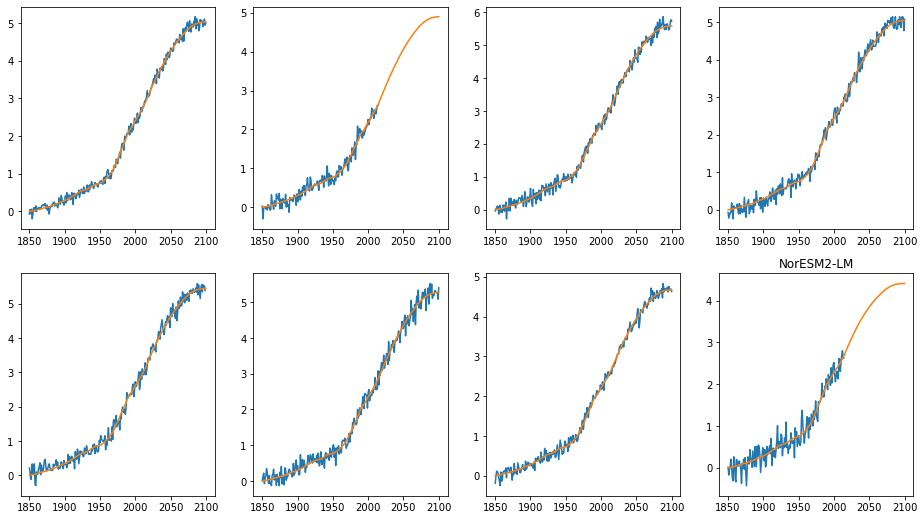

In [37]:
fig, ax = pl.subplots(2, 4, figsize=(16,9))

for imod, model in enumerate(models):
    ax[imod//4, imod%4].plot(np.arange(1850, 2101), ghg['%s GHG' % model])
    ax[imod//4, imod%4].plot(np.arange(1850, 2101), erf[model]['ssp245']['ghg'])
ax[imod//4, imod%4].set_title(model)

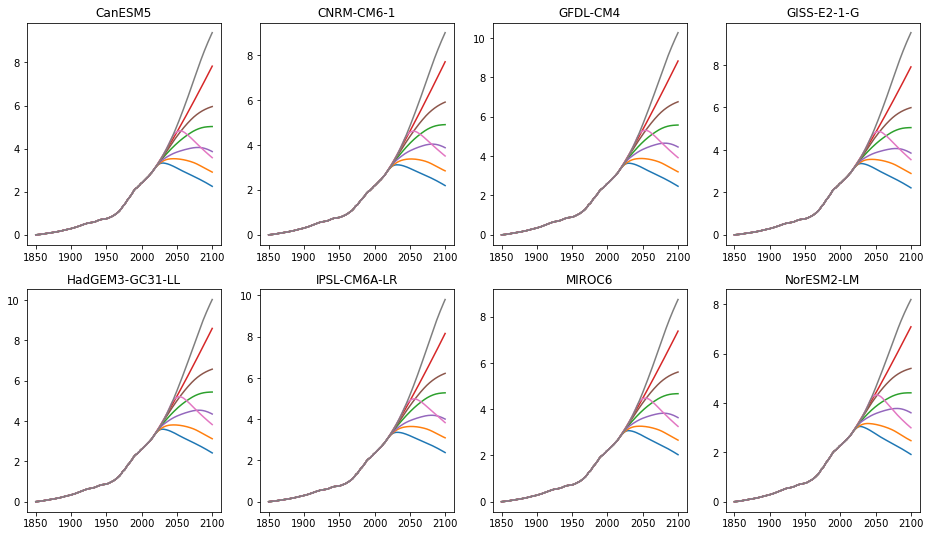

In [38]:
fig, ax = pl.subplots(2, 4, figsize=(16,9))

for iscen, scenario in enumerate(scenarios):
    for imod, model in enumerate(models):
        ax[imod//4, imod%4].plot(np.arange(1850, 2101), erf[model][scenario]['ghg'])
        ax[imod//4, imod%4].set_title(model)

## Apportion remaining forcing between land use and ozone

Land use: use 2014 - 1850 Tier 1, and base on AR6 / FaIR cumulative AFOLU CO2 relationship

In [39]:
rfmip_tier1 = pd.read_csv('../data_input/RFMIP-ERF-tier1.csv', index_col=0)
rfmip_tier1.loc['CanESM5', 'ghg']

2.8665463345516327

In [40]:
# residual anthro = land use + ozone
rfmip_tier2['CanESM5 TOT'] - rfmip_tier2['CanESM5 NAT'] - rfmip_tier2['CanESM5 AER'] - rfmip_tier2['CanESM5 GHG']

year
1850   -0.119088
1851    0.107184
1852    0.208994
1853    0.280191
1854    0.181272
          ...   
2096    0.293007
2097    0.337187
2098    0.157096
2099   -0.203044
2100    0.455431
Length: 251, dtype: float64

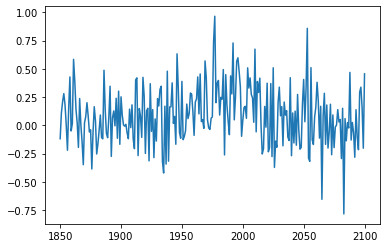

In [41]:
pl.plot(rfmip_tier2['CanESM5 TOT'] - rfmip_tier2['CanESM5 NAT'] - rfmip_tier2['CanESM5 AER'] - rfmip_tier2['CanESM5 GHG'])

In [42]:
# ozone in 2014
rfmip_tier1.loc['CanESM5', 'anthro'] - rfmip_tier1.loc['CanESM5', 'ghg'] - rfmip_tier1.loc['CanESM5', 'lu'] - rfmip_tier1.loc['CanESM5', 'aer']

0.4346189768741709

In [43]:
# land use in 2014
rfmip_tier1.loc['CanESM5', 'lu']

-0.0761294679087375

In [44]:
(rfmip_tier2['CanESM5 TOT'] - rfmip_tier2['CanESM5 NAT'] - rfmip_tier2['CanESM5 AER'] - rfmip_tier2['CanESM5 GHG']).loc[2014]

0.417148406902641

In [45]:
specie = 'CO2|MAGICC AFOLU'
cumulative_co2 = {}
for scenario in scenarios:
    emissions[scenario][specie] = emissions_df.loc[
        (emissions_df['Scenario']==scenario) & 
        (emissions_df['Variable']=='Emissions|{}'.format(specie)) &
        (emissions_df['Region']=='World'), 
        '1850':'2100'
    ].interpolate(axis=1).values.squeeze()
    cumulative_co2[scenario] = np.cumsum(emissions[scenario][specie]) - emissions[scenario][specie][0]

In [46]:
cumulative_co2[scenario]

array([     0.        ,   1812.64169067,   3830.60048229,   5841.02963163,
         7844.52817202,   9837.10121156,  11851.53992471,  13885.53082936,
        15936.65667488,  18015.80988711,  20111.52764802,  22248.24922713,
        24164.59546712,  26081.59300209,  27999.86241539,  29920.94979284,
        31842.53545932,  33758.58814737,  35669.28687211,  37573.95941216,
        39474.60458886,  41449.06400817,  43736.54990709,  46064.19804279,
        48418.45425872,  50801.52250183,  53212.87617233,  55648.61195471,
        58109.60191088,  60596.35121234,  63105.97446054,  65753.99937392,
        68225.22356532,  70722.37525307,  73231.36132059,  75762.99454466,
        78298.55286884,  80833.92999166,  83368.04038955,  85900.35309795,
        88420.62345444,  90928.61229802,  93489.8085838 ,  96053.8697513 ,
        98676.07934503, 101317.94393209, 103968.95384892, 106628.89578778,
       109297.9926095 , 111967.7475227 , 114644.89070174, 117565.11108684,
       120497.68917064, 1

In [47]:
for model in models:
    for scenario in scenarios:
        erf[model][scenario]['lu'] = np.nanmean(rfmip_tier1.loc[model, 'lu']) * cumulative_co2[scenario] / cumulative_co2[scenario][164]

/var/folders/6q/3d6ldw_97jq9lq39ckxj292c0000gn/T/ipykernel_20214/2320194319.py:3: RuntimeWarning: Mean of empty slice
  erf[model][scenario]['lu'] = np.nanmean(rfmip_tier1.loc[model, 'lu']) * cumulative_co2[scenario] / cumulative_co2[scenario][164]


In [48]:
# is it safe to assume that CNRM land use is zero?
for scenario in scenarios:
    erf['CNRM-CM6-1'][scenario]['lu'] = np.zeros(251)

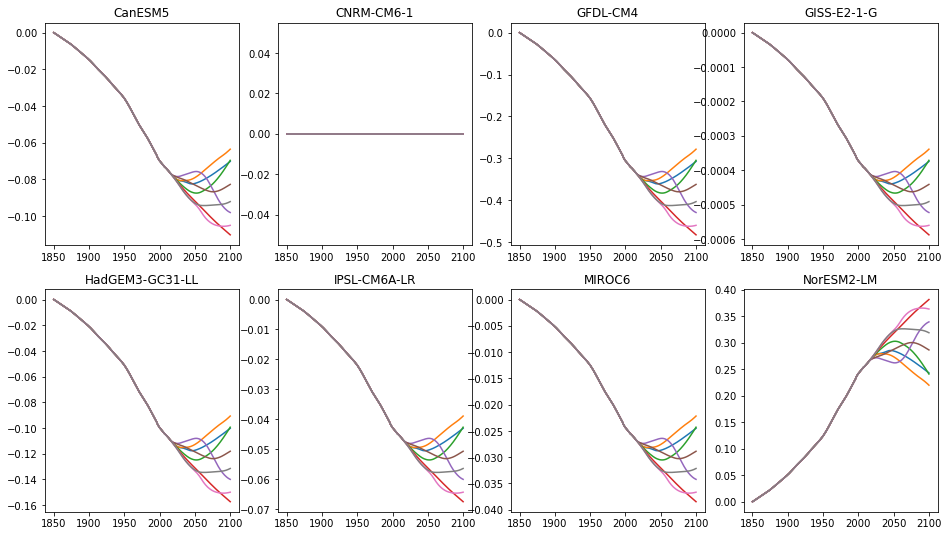

In [49]:
fig, ax = pl.subplots(2, 4, figsize=(16,9))

for iscen, scenario in enumerate(scenarios):
    for imod, model in enumerate(models):
        ax[imod//4, imod%4].plot(np.arange(1850, 2101), erf[model][scenario]['lu'])
        ax[imod//4, imod%4].set_title(model)

In [50]:
(rfmip_tier2['NorESM2-LM TOT'] - rfmip_tier2['NorESM2-LM NAT'] - rfmip_tier2['NorESM2-LM AER'] - rfmip_tier2['NorESM2-LM GHG']).loc[2014]

1.004336295934357

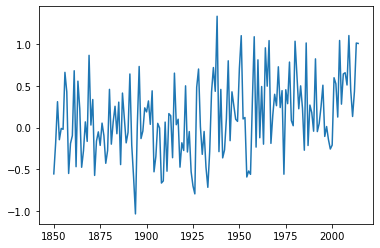

In [51]:
pl.plot(rfmip_tier2['NorESM2-LM TOT'] - rfmip_tier2['NorESM2-LM NAT'] - rfmip_tier2['NorESM2-LM AER'] - rfmip_tier2['NorESM2-LM GHG'])

In [52]:
rfmip_tier1.loc['NorESM2-LM', 'lu']

0.2632879170234761

In [53]:
rfmip_tier1.loc['NorESM2-LM', 'anthro'] - rfmip_tier1.loc['NorESM2-LM', 'ghg'] - rfmip_tier1.loc['NorESM2-LM', 'lu'] - rfmip_tier1.loc['NorESM2-LM', 'aer']

0.2041621799381086

In [54]:
# For ozone, the best I think we can go on is taking the Tier 1 residual and scaling based on the AR6 forcing projections
# CNRM: assume land use = 0

ozone_2014 = {}
for model in models:
    ozone_2014[model] = np.nanmean(rfmip_tier1.loc[model, 'anthro'] - rfmip_tier1.loc[model, 'ghg'] - rfmip_tier1.loc[model, 'lu'] - rfmip_tier1.loc[model, 'aer'])
ozone_2014['CNRM-CM6-1'] = rfmip_tier1.loc['CNRM-CM6-1', 'anthro'] - rfmip_tier1.loc['CNRM-CM6-1', 'ghg'] - rfmip_tier1.loc['CNRM-CM6-1', 'aer']

/var/folders/6q/3d6ldw_97jq9lq39ckxj292c0000gn/T/ipykernel_20214/2115061002.py:6: RuntimeWarning: Mean of empty slice
  ozone_2014[model] = np.nanmean(rfmip_tier1.loc[model, 'anthro'] - rfmip_tier1.loc[model, 'ghg'] - rfmip_tier1.loc[model, 'lu'] - rfmip_tier1.loc[model, 'aer'])


In [55]:
ozone_2014

{'CanESM5': 0.4346189768741709,
 'CNRM-CM6-1': 0.023460295909660367,
 'GFDL-CM4': 0.2693994529636271,
 'GISS-E2-1-G': 0.35450322526749634,
 'HadGEM3-GC31-LL': -0.08437617000654973,
 'IPSL-CM6A-LR': 0.18168210317962438,
 'MIROC6': 0.19631947568340324,
 'NorESM2-LM': 0.2041621799381086}

In [56]:
ozone_tier2_estimate = {}
for model in models:
    ozone_tier2_estimate[model] = rfmip_tier2['%s ANT' % model] - rfmip_tier2['%s AER' % model] - rfmip_tier2['%s GHG' % model] - erf[model]['ssp245']['lu']

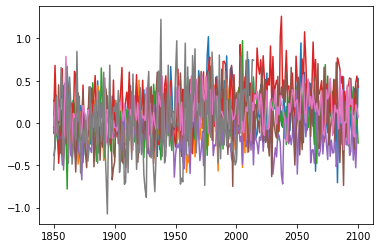

In [57]:
for model in models:
    pl.plot(ozone_tier2_estimate[model])

In [58]:
def ozone_fit(x, scale):
    return scale*x

In [59]:
mkdir_p('../data_input/ar6_erf')
subtables ={
    'ssp119': 'a',
    'ssp126': 'b',
    'ssp245': 'c',
    'ssp370': 'd',
    'ssp585': 'e',
    'ssp434': 'x',
    'ssp460': 'x',
    'ssp534-over': 'x'
}
for scenario in scenarios:  # needs fixing on Zenodo, not trivial
    if scenario=='ssp434':
        suffix='.csv'
    else:
        suffix=''
    print(scenario)
    check_and_download(
        '../data_input/ar6_erf/%s_ERF_1750-2500_best_estimate.csv' % scenario,
        'https://zenodo.org/record/5705391/files/table_A3.4%s_%s_ERF_1750-2500_best_estimate.csv%s' % (subtables[scenario], scenario, suffix)
    )

ssp119
ssp126
ssp245
ssp370
ssp434
ssp460
ssp534-over
ssp585


In [60]:
ssp_ozone = {}
for scenario in scenarios:
    df = pd.read_csv('../data_input/ar6_erf/%s_ERF_1750-2500_best_estimate.csv' % scenario)
    ssp_ozone[scenario] = df.loc[100:350, 'o3'].values - df.loc[100:350, 'o3'].values[0]

In [61]:
ozone_scaling_factors = {}

end = {model: 251 for model in models}
end['HadGEM3-GC31-LL'] = 250
end['NorESM2-LM'] = 165
end['CNRM-CM6-1'] = 165

for model in models:
    p, cov = curve_fit(
        ozone_fit, 
        ssp_ozone['ssp245'][:end[model]],
        ozone_tier2_estimate[model][:end[model]],
    )
    ozone_scaling_factors[model] = p[0]

In [62]:
ozone_scaling_factors

{'CanESM5': 0.5462554886366293,
 'CNRM-CM6-1': -0.08848497625289276,
 'GFDL-CM4': 0.3788681235802092,
 'GISS-E2-1-G': 1.1125957129137134,
 'HadGEM3-GC31-LL': -0.5075785998790285,
 'IPSL-CM6A-LR': 0.375315641117015,
 'MIROC6': 0.4911603595879458,
 'NorESM2-LM': 0.34835053982855413}

In [63]:
for model in models:
    for scenario in scenarios:
        erf[model][scenario]['ozone'] = ssp_ozone[scenario] * ozone_scaling_factors[model]

Text(0.5, 1.0, 'NorESM2-LM')

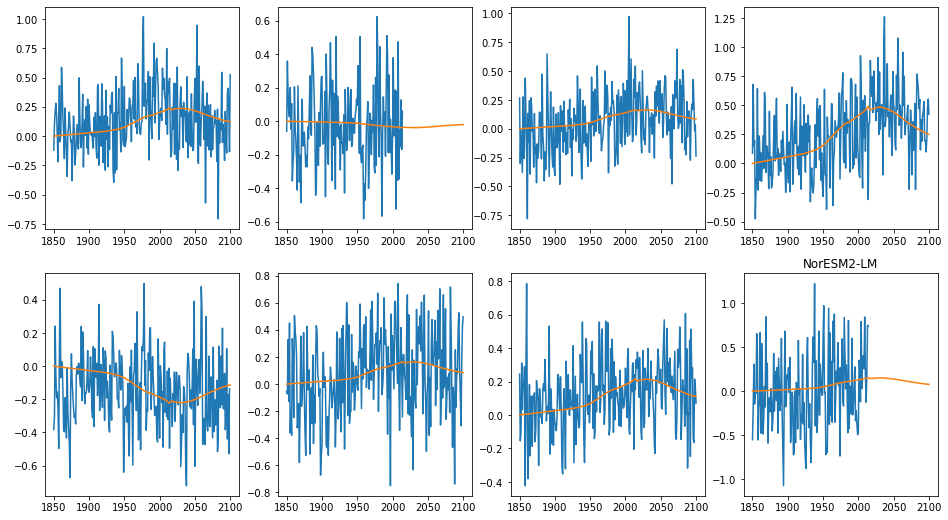

In [64]:
fig, ax = pl.subplots(2, 4, figsize=(16,9))

for imod, model in enumerate(models):
    ax[imod//4, imod%4].plot(np.arange(1850, 2101), ozone_tier2_estimate[model])
    ax[imod//4, imod%4].plot(np.arange(1850, 2101), erf[model]['ssp245']['ozone'])
ax[imod//4, imod%4].set_title(model)

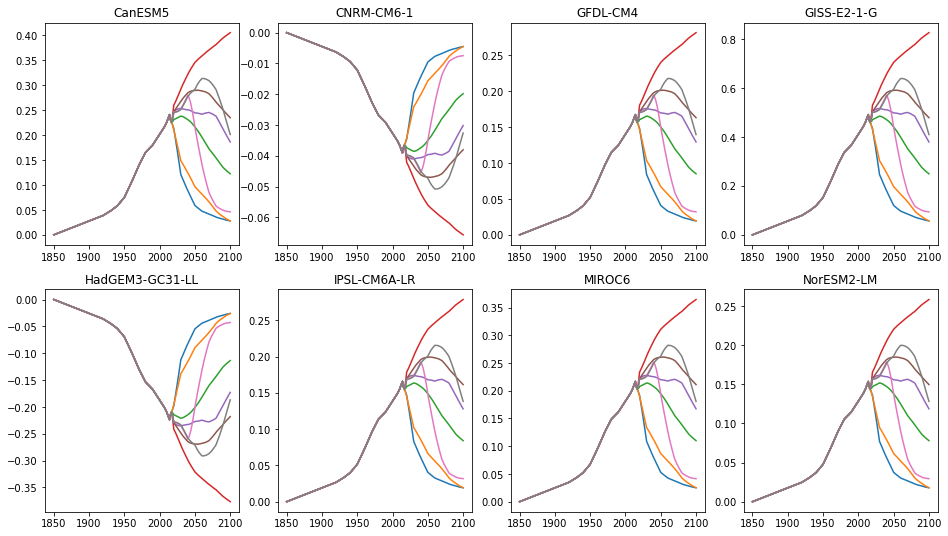

In [65]:
fig, ax = pl.subplots(2, 4, figsize=(16,9))

for iscen, scenario in enumerate(scenarios):
    for imod, model in enumerate(models):
        ax[imod//4, imod%4].plot(np.arange(1850, 2101), erf[model][scenario]['ozone'])
        ax[imod//4, imod%4].set_title(model)

## Sum everything up

In [66]:
for model in models:
    for scenario in scenarios:
        erf[model][scenario]['Total'] = (
            erf[model][scenario]['ghg'] +
            erf[model][scenario]['aerosol'] +
            erf[model][scenario]['lu'] + 
            erf[model][scenario]['ozone'] + 
            erf[model][scenario]['natural']
        )

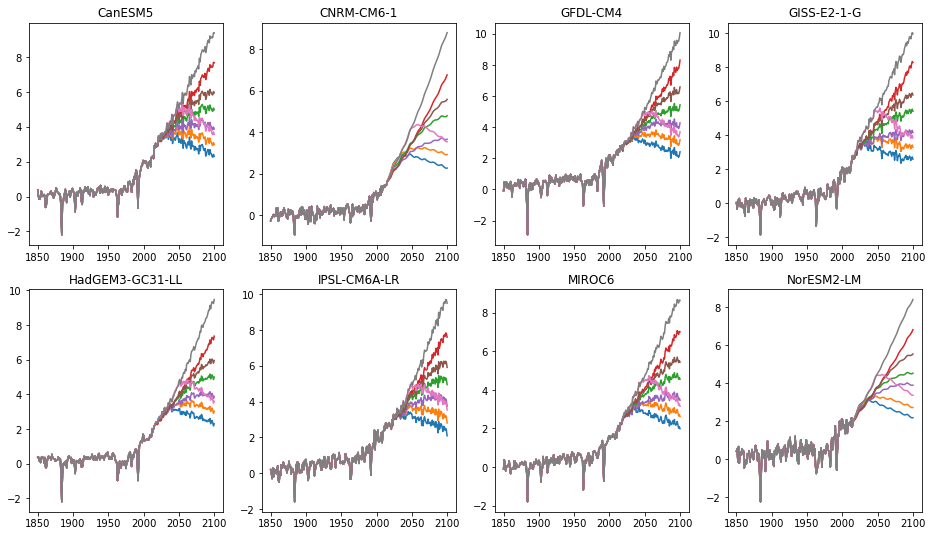

In [67]:
fig, ax = pl.subplots(2, 4, figsize=(16,9))

for iscen, scenario in enumerate(scenarios):
    for imod, model in enumerate(models):
        ax[imod//4, imod%4].plot(np.arange(1850, 2101), erf[model][scenario]['Total'])
        ax[imod//4, imod%4].set_title(model)

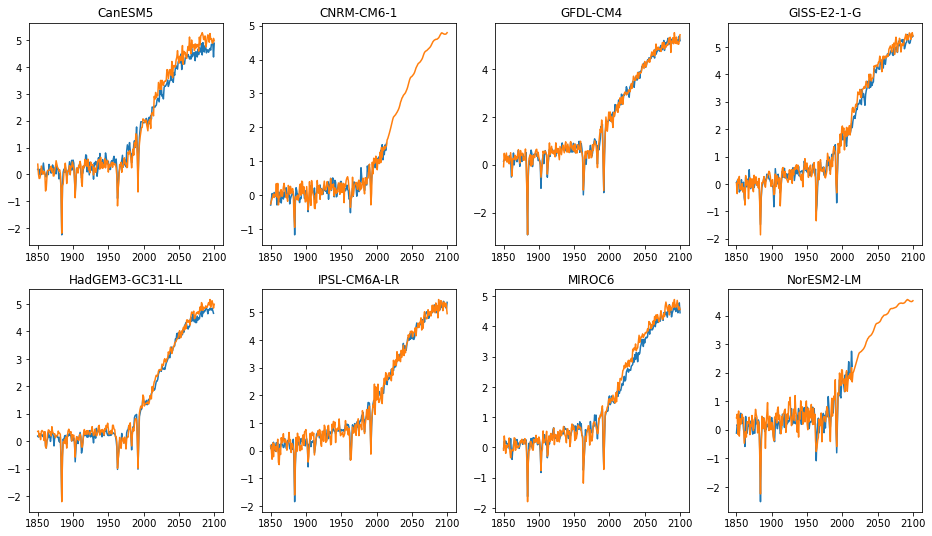

In [68]:
fig, ax = pl.subplots(2, 4, figsize=(16,9))

for imod, model in enumerate(models):
    ax[imod//4, imod%4].plot(np.arange(1850, 2101), rfmip_tier2['%s TOT' % model])
    ax[imod//4, imod%4].plot(np.arange(1850, 2101), erf[model]['ssp245']['Total'])
    ax[imod//4, imod%4].set_title(model)

In [69]:
mkdir_p('../data_output/model_emulated_ssp_forcing/')

In [70]:
for model in models:
    for scenario in scenarios:
        df = pd.DataFrame(erf[model][scenario], index=np.arange(1850, 2101))
        df.to_csv('../data_output/model_emulated_ssp_forcing/%s_%s.csv' % (model, scenario))